## HelloFresh Data Scientist Assignment
### Project: Customer churn predictor 
### Vasily Korf, Aug 2017

### Goal
Explore the datasets and develop a model to predict either customer churn over time.

In this project, you will employ several supervised algorithms of my choice to accurately model customers' churn. 

### Exploring the Data

Run the code cell below to load necessary Python libraries and load the data. 

In [1]:
# Import libraries necessary for this project
import pandas as pd
import numpy as np
import scipy.stats as st

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import visuals as vs
from IPython.display import display 

from datetime import datetime
from time import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, auc, precision_score, recall_score, roc_curve, f1_score, roc_auc_score, cohen_kappa_score

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier)
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import BaggingClassifier
#from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
# Load tables
boxes = pd.read_csv("boxes.csv")
errors = pd.read_csv("errors.csv")
cancels = pd.read_csv("cancels.csv")
pauses = pd.read_csv("pauses.csv")
# Display the first 3 records of each table
display(boxes.head(n=3))
display(errors.head(n=3))
display(cancels.head(n=3))
display(pauses.head(n=3))

,Unnamed: 0,subscription_id,box_id,delivered_at,started_week,count_boxes,product,channel
0,1,1000001,US3598,2013-01-14 00:00:00,2013-W03,1,type1,channel1
1,2,1000001,US3899,2013-01-21 00:00:00,2013-W03,2,type1,channel1
2,3,1000001,US4175,2013-01-28 00:00:00,2013-W03,3,type1,channel1


,subscription_id,refund_amount,created_at
0,1000273,69.0,2016-02-25 03:58:11
1,1000305,69.0,2014-12-18 16:48:29
2,1000361,34.5,2015-09-12 18:30:24


,subscription_id,delivery_weekday,canceled_at
0,1000001,3,2013-01-29
1,1000002,3,2013-01-30
2,1000003,3,2013-06-03


,subscription_id,pause_start,pause_end
0,1000003,2013-06-10,2013-06-16
1,1000003,2013-06-17,2013-06-23
2,1000003,2013-06-24,2013-06-30


In [3]:
# Drop first unnamed column (Unnamed: 0) from boxes table
boxes.drop(boxes.columns[[0]], axis=1, inplace=True)

#### Implementation: Data Preprocessing
From the table in Exploring the Data above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called categorical variables) be converted. One popular way to convert categorical variables is by using the one-hot encoding scheme. One-hot encoding creates a "dummy" variable for each possible category of each non-numeric feature.

In [4]:
## Product table
encode_product = pd.get_dummies(boxes.iloc[:,5])
encode_channel = pd.get_dummies(boxes.iloc[:,6])
# Add product
result = pd.concat([boxes, encode_product], axis=1)
# Add channel
result = pd.concat([result, encode_channel], axis=1)
# Drop old columns
product_type = result.drop(result.columns[1:7], axis=1)

product_type = product_type.drop_duplicates()

In [5]:
product_type.head()

,subscription_id,type1,type2,type3,channel1,channel10,channel11,channel12,channel13,channel14,channel15,channel16,channel17,channel18,channel19,channel2,channel20,channel21,channel22,channel23,channel24,channel25,channel26,channel27,channel28,channel29,channel3,channel30,channel31,channel32,channel33,channel34,channel4,channel5,channel6,channel7,channel8,channel9
0,1000001,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1000002,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1000003,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,1000004,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1000005,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


**Feature insights**: no switching between product types and channels.

In [6]:
### Pauses table 

# Convert string to date
pauses.iloc[:,1] = pd.to_datetime(pauses.iloc[:,1], format='%Y-%m-%d')
pauses.iloc[:,2] = pd.to_datetime(pauses.iloc[:,2], format='%Y-%m-%d')

# Add column with pause duration
pauses['diff_days'] = pauses['pause_end'] - pauses['pause_start'] 
#pauses.describe()

# Fix typo
pauses['pause_end'][pauses.diff_days == '-360 days'] = '2017-01-06'

# Add date of the first pause_start, Number of pauses, date of the last pause_end by subscription_id
grouped_pauses = pauses.groupby('subscription_id')
pre_pauses = grouped_pauses.agg({'pause_start' : ['min','size'], 'pause_end' : ['max']}).reset_index()
pre_pauses.columns = ['subscription_id','first_pause_start','pauses_count','last_pause_end']
pre_pauses.iloc[:,3] = pd.to_datetime(pre_pauses.iloc[:,3], format='%Y-%m-%d')
pre_pauses.head()

,subscription_id,first_pause_start,pauses_count,last_pause_end
0,1000003,2013-06-10,3,2013-06-30
1,1000009,2013-02-04,32,2013-09-29
2,1000010,2013-01-28,6,2013-03-31
3,1000011,2013-01-21,48,2013-12-22
4,1000014,2013-01-14,4,2013-02-03


** Featureset description **

* **first_pause_start**: first pause date. 
* **pauses_count**: number of pauses. 
* **last_pause_end**: last pause date. 

In [7]:
### Errors table

# Convert to date
errors.iloc[:,2] = pd.to_datetime(pauses.iloc[:,2], format='%Y-%m-%d')

# Group and add features
grouped_errors = errors.groupby('subscription_id')
pre_error = grouped_errors.agg({'refund_amount' : ['sum','max','min','mean','size'], 
                                'created_at' : ['min','max']}).reset_index()
pre_error.columns = ['subscription_id','created_at_min','created_at_max','refund_amount_sum',
                     'refund_amount_max','refund_amount_min','refund_amount_mean','refund_amount_size']
pre_error.head()

,subscription_id,created_at_min,created_at_max,refund_amount_sum,refund_amount_max,refund_amount_min,refund_amount_mean,refund_amount_size
0,1000273,2013-06-16,2013-06-16,69.0,69.0,69.0,69.0,1
1,1000305,2013-06-23,2013-06-23,69.0,69.0,69.0,69.0,1
2,1000361,2013-02-10,2013-06-30,69.0,34.5,34.5,34.5,2
3,1000439,2013-02-17,2013-02-17,10.0,10.0,10.0,10.0,1
4,1000492,2013-02-24,2013-02-24,69.0,69.0,69.0,69.0,1


** Featureset description **

* **created_at_min**: first refund date. 
* **refund_amount_size**: number of refunds. 
* **created_at_max**: last refund date. 
* **refund_amount_sum**: total refund amount. 
* **refund_amount_max**: maximum refund amount. 
* **refund_amount_min**: minimum refund amount. 
* **refund_amount_mean**: average refund amount. 

In [8]:
### Boxes table

# Convert to date
boxes.iloc[:,2] = pd.to_datetime(boxes.iloc[:,2], format='%Y-%m-%d %H:%M:%S')
# Group and add features
grouped_boxes = boxes.groupby('subscription_id')
pre_boxes = grouped_boxes.agg({'delivered_at' : ['max','min','size'], 
                                'count_boxes' : ['min','max']}).reset_index()
pre_boxes.columns = ['subscription_id', 'check_min', 'check_max','last_delivered_date', 'first_delivered_date', 'count_boxes']
pre_boxes.head()


,subscription_id,check_min,check_max,last_delivered_date,first_delivered_date,count_boxes
0,1000001,1,3,2013-01-28,2013-01-14,3
1,1000002,1,1,2013-01-28,2013-01-28,1
2,1000003,1,1,2013-01-14,2013-01-14,1
3,1000004,1,2,2013-01-28,2013-01-21,2
4,1000005,1,3,2013-01-28,2013-01-14,3


** Featureset description **

* **first_delivered_date**: first delivery date. 
* **count_boxes**: number of boxes. 
* **last_delivered_date	**: last delivery date. 
* **check_min**: tedt value - must equels 1. 
* **check_max**: test value - total number of boxes.  

In [9]:
### Cancels table
# Convert to date
cancels.iloc[:,2] = pd.to_datetime(cancels.iloc[:,2], format='%Y-%m-%d')

### Merge all data

In [10]:
# Join all tables
join1 = pd.merge(pre_boxes,pre_pauses,how='left',on='subscription_id')
join2 = pd.merge(join1,pre_error,how='left',on='subscription_id')
join3 = pd.merge(join2,cancels,how='left',on='subscription_id')
df = pd.merge(join3,product_type,how='left',on='subscription_id')
# Add churn feature
df['churn'] = pd.notnull(df['canceled_at'])
# Convert boolean to int
df['churn'] = df['churn'].astype(int)
# Add current date column (last_delivered_date.max)
#df['current_date'] = pd.to_datetime('2016-11-07', format='%Y-%m-%d')

### New features processing

In [11]:
## Add new features releated to customer's age
# Delivery delta
df['diff_delivery'] = df['last_delivered_date'] - df['first_delivered_date']
# Set format
df['diff_delivery'] = df['diff_delivery'].dt.days

# Diff last delivery and cancel
df['diff_delivery_cancel'] = df['canceled_at'] - df['last_delivered_date']
# Set format
df['diff_delivery_cancel'] = df['diff_delivery_cancel'].dt.days

# Diff last and first pause
df['diff_last_firstpause'] = df['last_pause_end'] - df['first_pause_start']
# Set format
df['diff_last_firstpause'] = df['diff_last_firstpause'].dt.days

# Diff last and first refund
df['diff_last_firstrefund'] = df['created_at_max'] - df['created_at_min']
# Set format
df['diff_last_firstrefund'] = df['diff_last_firstrefund'].dt.days


** Featureset description **

* **diff_delivery**: the difference between last and first delivery date. 
* **diff_delivery_cancel**:  the difference between cancellation date and first delivery date. 
* **diff_last_firstpause**: the difference between last and first pause date.  
* **diff_last_firstrefund**: the difference between last and first refund date.

### Data cleaning

In [12]:
# Drop rows with first count_boxes > 1
df.drop(df[df.check_min > 1].index, inplace=True)
# Drop rows with check_max != count_boxes 
df.drop(df.ix[df['check_max']!=df['count_boxes']].index, inplace=True)
# Drop rows with cancelation date <  first delivery date 
df.drop(df.ix[df['canceled_at'] < df['first_delivered_date']].index, inplace=True)
# Drop rows with first refund date <  first delivery date 
df.drop(df.ix[df['created_at_min'] < df['first_delivered_date']].index, inplace=True)
# Drop rows with (cancelation date - last delivery date) <  -7
df.drop(df[df.diff_delivery_cancel < -7].index, inplace=True)
# Drop rows with (cancelation date - last delivery date) <  -7
df.drop(df.ix[df['first_pause_start'] < df['first_delivered_date']].index, inplace=True)

# Drop rows with pauses count > 8
#df.drop(df[df.pauses_count > 8].index, inplace=True)

#Check outliers by id
#boxes.ix[boxes['subscription_id']==1000013]
#errors.ix[errors['subscription_id']==1015563]
#df.ix[df['check_max']!=df['count_boxes']]
#df['last_pause_end'].max()
#df[df['diff_last_firstrefund']>0]

**Data insight**: the code above helps to clean data set and drop 25% weird and unlogical data.

In [13]:
# Check list of unique values by each feature
uniq = df.apply(lambda x: len(np.unique(np.array(x))))
#uniq

In [14]:
# Drop channel 27 - no information in this column
df.drop(['channel27'], axis=1, inplace=True)

### Final clean dataset

In [15]:
# Make df copy
data = df.copy()
# Drop columns with date
data.drop(['last_delivered_date', 'delivery_weekday', 'first_delivered_date',
           'first_pause_start', 'last_pause_end','created_at_min', 'created_at_max', 'diff_delivery_cancel',
           'canceled_at', 'check_min', 'check_max'], axis=1, inplace=True)
# Fill NaN
data = data.fillna(0)
# Set subscription_id as df index
data.set_index('subscription_id', inplace=True)

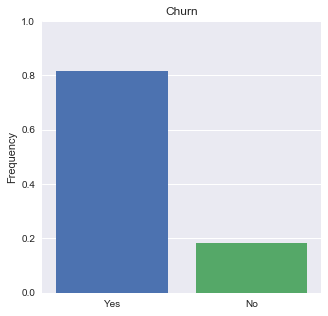

In [16]:
# Churn rate plot
fig = plt.figure(figsize=(5, 5))
y = ["Yes", "No"]
ax = sns.categorical.barplot(y, np.array(data.churn.value_counts(normalize=True)), saturation=1)
ax.set_xticklabels(y)
ax.set_title("Churn")
#ax.set_xlabel("")
ax.set_ylabel("Frequency")
ax.set_ylim([0,1])
plt.show()

**Data insight**: You may see an unbalanced data. We can not use accuracy, **ROC AUC** metric works better, such as that which is well suited for unbalanced binary samples and few TN samples. 

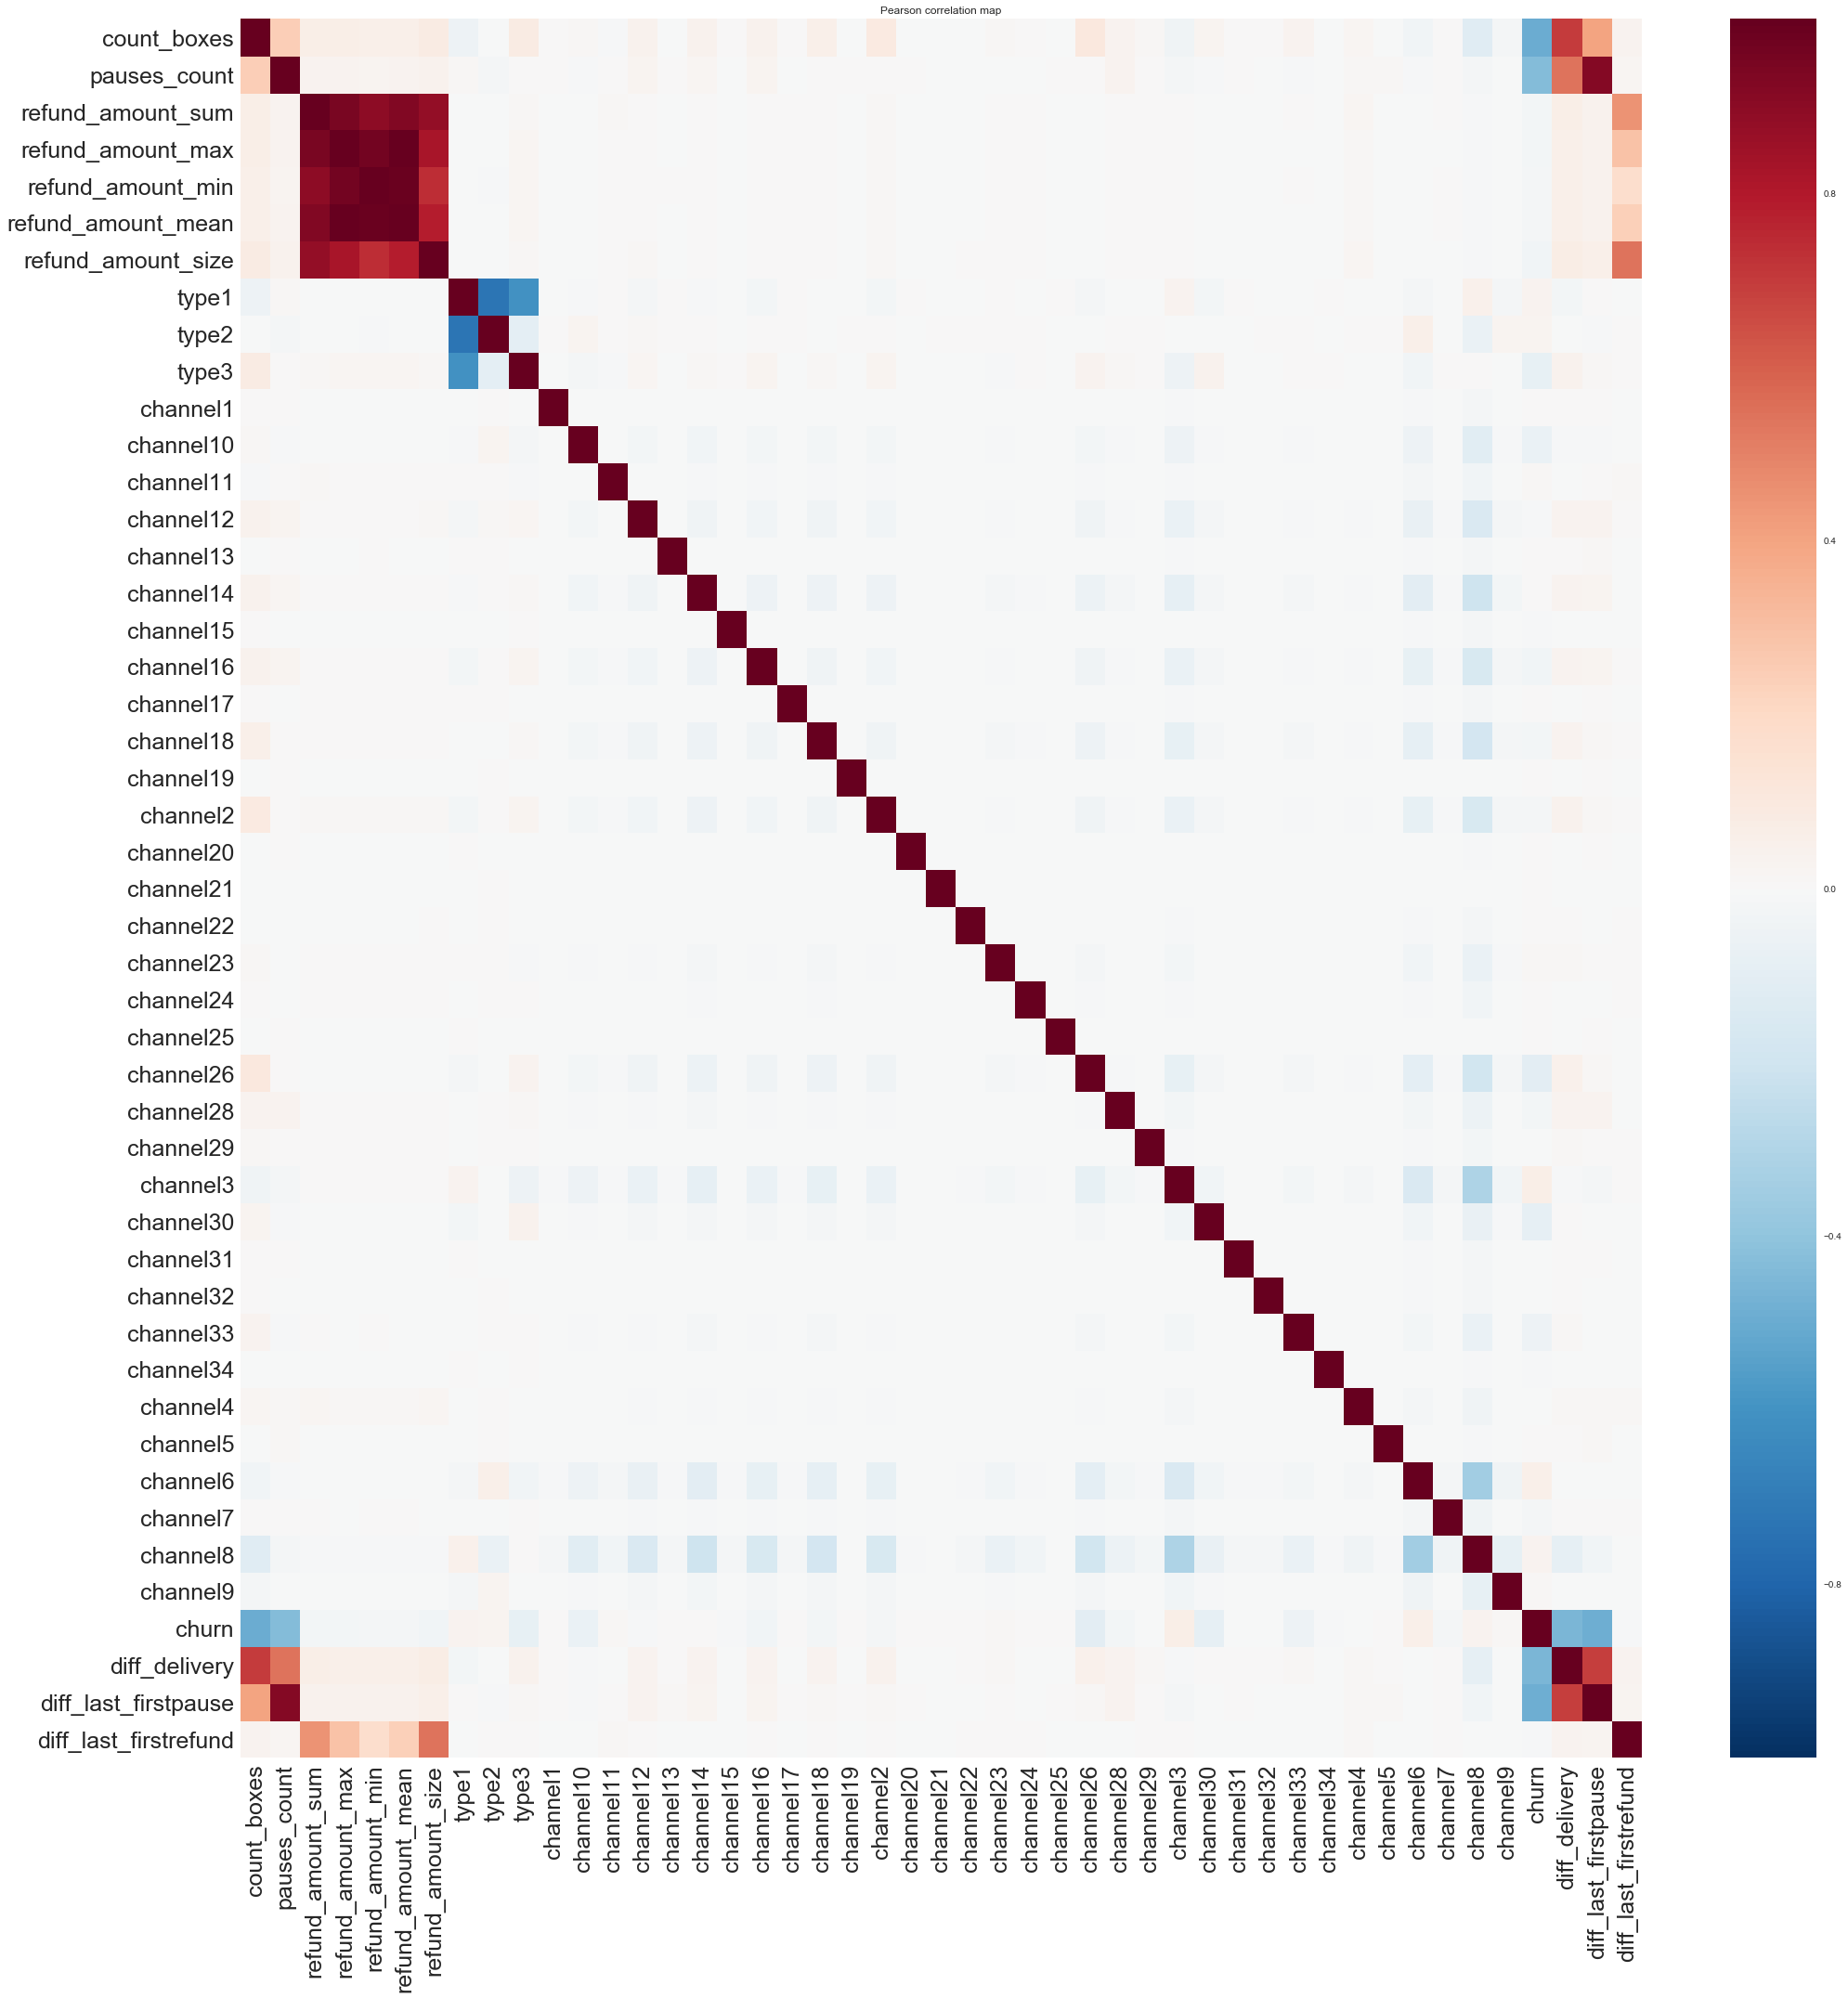

In [17]:
# Plot correlation map
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(1,1,1)
corr_data = data.select_dtypes(["number"]).corr()
sns.heatmap(corr_data, ax=ax)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_title("Pearson correlation map")
plt.tight_layout()
plt.show()

In [18]:
data.head()

,count_boxes,pauses_count,refund_amount_sum,refund_amount_max,refund_amount_min,refund_amount_mean,refund_amount_size,type1,type2,type3,channel1,channel10,channel11,channel12,channel13,channel14,channel15,channel16,channel17,channel18,channel19,channel2,channel20,channel21,channel22,channel23,channel24,channel25,channel26,channel28,channel29,channel3,channel30,channel31,channel32,channel33,channel34,channel4,channel5,channel6,channel7,channel8,channel9,churn,diff_delivery,diff_last_firstpause,diff_last_firstrefund
subscription_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000001,3,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,14,0.0,0.0
1000002,1,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0
1000003,1,3.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,20.0,0.0
1000004,2,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,0.0,0.0
1000005,3,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,14,0.0,0.0


### Churn correlation

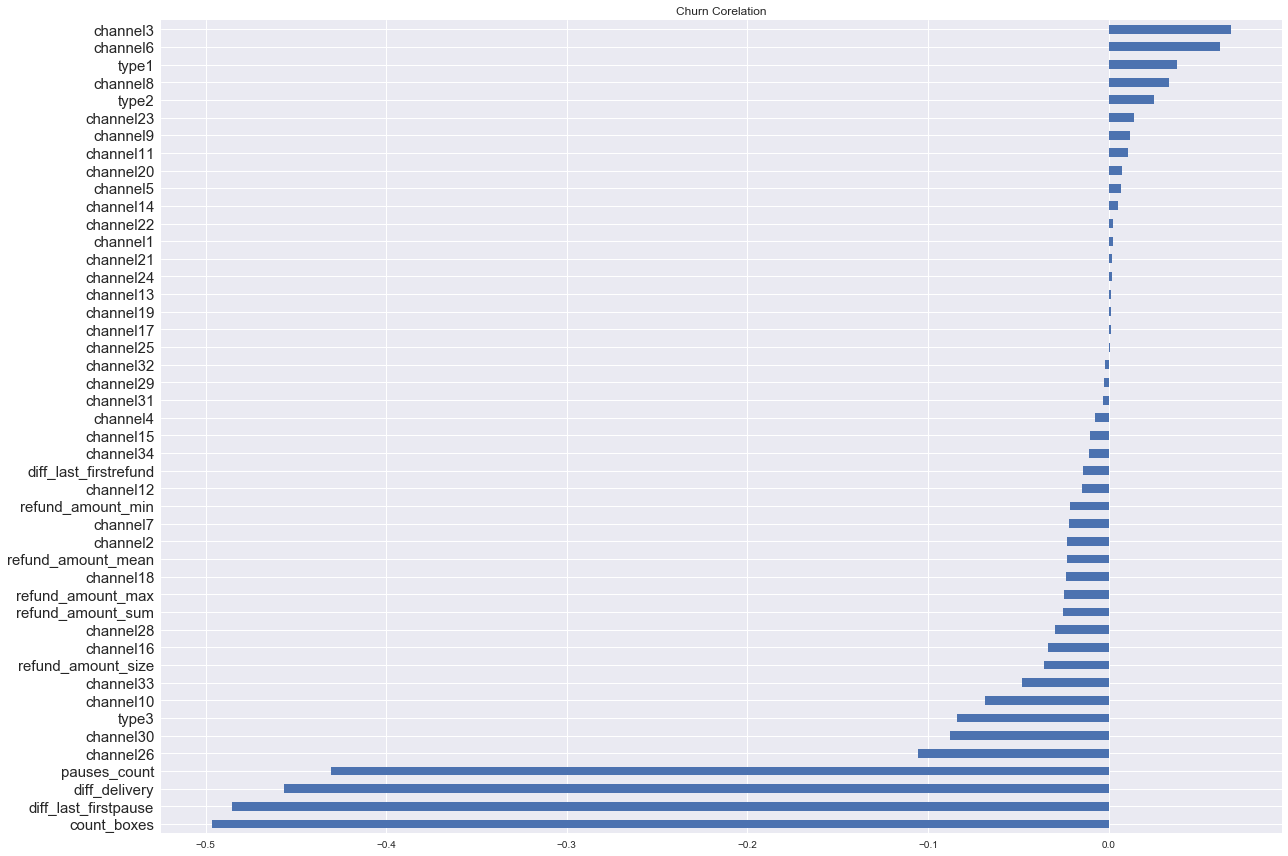

In [19]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
ax = data.corr().ix['churn'].drop('churn').sort_values().plot(kind='barh', figsize=(18, 12), ax=ax)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_title('Churn Corelation')
plt.tight_layout()

### Building and Learning Model


###  Supervised Learning Models
**The following are some of the supervised learning models in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

I'd like to pick simple Logistic Regression, popular SVM, Stochastic Gradient Descent Classifier and Random Forest.

**Logistic Regression**
* Economy, marketing, ads https://scholar.google.de/scholar?q=logistic+regression+study&btnG=&hl=en&as_sdt=0%2C5&as_vis=1
* Simple, fast, easy to compute https://victorfang.wordpress.com/2011/05/10/advantages-and-disadvantages-of-logistic-regression/
* Overfitting, limited outcome variables, sensitive feature set http://classroom.synonym.com/disadvantages-logistic-regression-8574447.html
* Set a performance baseline for a model.

**SVM(SVC)**
* Major machine learning algorithm implemented in the field of health and medicine.
* Unlike Logistic Regression which predicts its output based on a determined model,SVM generates a hyperplane to separate the outcome after transforming the input variables that maximises the "margin or the distance between the points from this hyperplane"
* Convert input data that is linearly non-separable and transform them to linearly separable through the use of kernels
* It also accomodates regularization parameter that avoids overfitting the data
* Requires more time for training the data when comapared to other algorithms
* When the features become too complex,SVM fails

**Stochastic Gradient Descent Classifier (SGDC)**
* A popular use of SGDC is in the field of geophysics, more specifically in applications of Full Waveform Inversion (FWI).
* One of the great strengths of this especially when it is compared to the regular gradient descent method is 
that when there are large sets of data some of the data becomes redundant. This means that it is much faster.
* SGDC is better when the data available is quite noisy.
* The downfall of this method is that it does have a slower convergence time when compared to other second order gradient decent classifiers. 


**Random Forest Classifier**
* ability to deal with a huge amount of data contaning many different variables
* randomly selects a subset of data and forms a tree.This then repeats again and again until they form a forest with many different trees.Then a vote decides the output from the averaged predictions across all the trees.
* It depicts what predictors are important for the classification
* Can also be run parallel and is resistant to outliers
* Random forests are known to work well at times especially for classification problems and gives more accuracy and is fast. I believe this is a good model for the data.


Source:
1. http://blog.echen.me/2011/04/27/choosing-a-machine-learning-classifier/
2. https://docs.microsoft.com/en-us/azure/machine-learning/machine-learning-algorithm-choice
3. https://stackoverflow.com/questions/2595176/when-to-choose-which-machine-learning-classifier



In [45]:
# Make a copy
data1 = data.copy()
# Speed up 
#data1 = data1.sample(frac=0.2)

In [46]:
# Label X, Y data
Y = data1[['churn']].values.ravel()
X = data1.drop('churn', axis=1).values.astype('float64')

In [47]:
# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#shuffle_index = np.random.permutation(len(X_train))
#X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 238119 samples.
Testing set has 59530 samples.


In [26]:
#clf_A = GradientBoostingClassifier(random_state=0)
#clf_B = LogisticRegression(random_state=0)
#clf_C = SGDClassifier(random_state=0)
#clf_D = SVC(random_state=0)
#clf = RandomForestClassifier()
        
clf_A = LogisticRegression(random_state=0)
clf_B = SVC(random_state=0)
clf_C = SGDClassifier(random_state=0)
clf_D = RandomForestClassifier(n_estimators=100)

clf_A.fit(X_train, y_train)
clf_B.fit(X_train, y_train)
clf_C.fit(X_train, y_train)
clf_D.fit(X_train, y_train)

#print("Accuracy for train dataset: {}".format(clf.score(X_train, y_train)))
#print("Accuracy for test dataset: {}".format(clf.score(X_test, y_test)))
#print("F1: {}".format(f1_score(y_test, clf.predict(X_test))))
#print("Precision: {}".format(precision_score(y_test, clf.predict(X_test))))
#print("Recall: {}".format(recall_score(y_test, clf.predict(X_test))))
#plot_confusion_matrix(y_test, clf.predict(X_test))

print ("LogisticRegression\n------")
print("AUC ROC: {}".format(roc_auc_score(y_test, clf_A.predict(X_test))))
print ("SVC\n------")
print("AUC ROC: {}".format(roc_auc_score(y_test, clf_B.predict(X_test))))
print ("SGDClassifier\n------")
print("AUC ROC: {}".format(roc_auc_score(y_test, clf_C.predict(X_test))))
print ("RandomForestClassifier\n------")
print("AUC ROC: {}".format(roc_auc_score(y_test, clf_D.predict(X_test))))

LogisticRegression
------
AUC ROC: 0.723125696562
SVC
------
AUC ROC: 0.717282909952
SGDClassifier
------
AUC ROC: 0.730895874166
RandomForestClassifier
------
AUC ROC: 0.77355468282


In [28]:
print("F1: {}".format(f1_score(y_test, clf_A.predict(X_test))))

F1: 0.925112752144


In [29]:
# Check ROC AUC with CV
cross_val_score(clf_D, X_train, y_train, cv=3, scoring="roc_auc")

array([ 0.90983881,  0.91149138,  0.90890467])

### Extracting Feature Importance

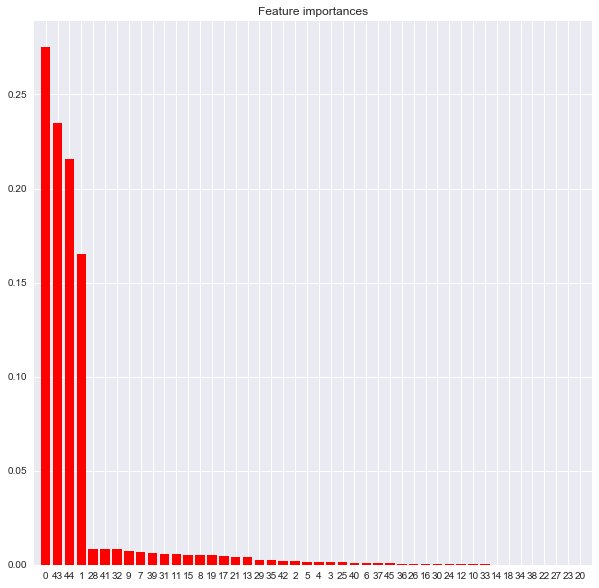

In [47]:
importances = clf_D.feature_importances_
std = np.std([clf_D.feature_importances_ for tree in clf_D.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(10, 10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [48]:
list(data1.drop('churn', axis=1).iloc[:,[0,43,44,1]].columns)

['count_boxes', 'diff_delivery', 'diff_last_firstpause', 'pauses_count']

**Model insight**: you can model with with only the top five important features dataset if you'd like to make faster predictions with less ROC AUC. I would never consider using the reduced model because finally what we need is to come up with an algorithm that makes a better prediction.

### Improving Results, Model Tuning

In [49]:
from sklearn.cross_validation import ShuffleSplit  
from sklearn.grid_search import GridSearchCV

param_grid = { 
    'n_estimators': [200, 400],
    'max_features': ['auto', 'sqrt', 'log2']

}

clf_D = RandomForestClassifier()

# Add CV
cv = ShuffleSplit(X_train.shape[0], n_iter=3, test_size=0.2, random_state=0)

CV_rfc = GridSearchCV(clf_D, param_grid=param_grid, cv= cv)
CV_rfc.fit(X_train, y_train)
#print CV_rfc.best_params_

GridSearchCV(cv=ShuffleSplit(238119, n_iter=3, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200, 400], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [50]:
print CV_rfc.best_params_

{'max_features': 'sqrt', 'n_estimators': 400}


In [51]:
# Get the estimator
best_clf = CV_rfc.best_estimator_

# Make predictions using the unoptimized and model

best_predictions = best_clf.predict(X_test)
print("AUC ROC: {}".format(roc_auc_score(y_test, best_predictions)))
print("F1: {}".format(f1_score(y_test, best_predictions)))


AUC ROC: 0.774746899274
F1: 0.928706599067


#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
    | ROC AUC |    0.7              |      0.763             |      0.774           |
| F-score        |      0.925                 |      0.926             |   0.928       |


The optimized model had a ROC AUC of 84.88% and F-score of 70%.These scores are better than the unoptimized model but only by a very small margin.But the results of the optimized model is way better than the predictor benchmarks as seen earlier.  The simple tuning of the model helps.

**Marketing recommendations**
* Dive into a lloylty program for loyal customers. Understand CLV trends and purchase cycles.
* Provide A/B testing for subscription cancellation features. 
* Add features usage in the data set.

#### Appendix. Learning curve plots

Automatically created module for IPython interactive environment


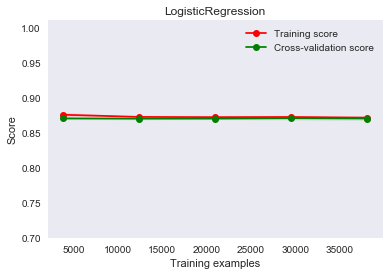

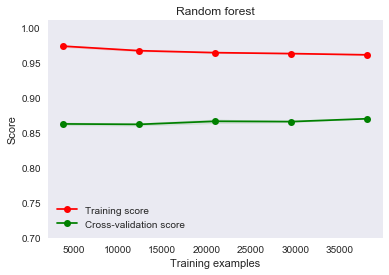

In [44]:
# source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
  
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)

title = "LogisticRegression"

plot_learning_curve(clf_A, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)


#title = "SVC"

#plot_learning_curve(clf_B, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

#title = "SGDClassifier"

#plot_learning_curve(clf_C, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Random forest"

plot_learning_curve(clf_D, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)


plt.show()